# Gradient Symbolic Computation

see `TPR_example.ipynb` for details about the TP representation and one possible empirical phenomenon, that can be handled with GSC.

In [37]:
# Imports
from src.classes.Grammar import Grammar
from src.gsc.gsc_network import Net
import pandas as pd
import torch
# Set seed for reproducibility
torch.manual_seed(123)

## Grammar and Harmonic Constraints

In [38]:
# Fillers and Roles
fillers = ["bh", "b", "u", "d", "dh"]
roles = ["s1", "s2", "s3"]

"""similarities = torch.tensor([[1, 0.75, 0, 0, 0],
                             [0.75, 1, 0, 0, 0],
                             [0, 0, 1, 0, 0],
                             [0, 0, 0, 1, 0.75],
                             [0, 0, 0, 0.75, 1]])"""

# Build Grammar
G = Grammar(fillers, roles, emtpyFiller="_")
#G = Grammar(fillers, roles, emtpyFiller="_", fillerSimilarities=similarities)

Buil Filler Matrix
Representations built after 132 attempts

Build role Matrix
Representations built after 145 attempts



__Single Constituents Harmony__

The following code sets the harmony values for single bindings. 
For instance the constraint `("b/s1", 2)` means that the segment "b" in first position ("s1") improves the general harmony by 2. 

There will be *Harmony crosstalk* if the vector representing those bindings are not independent (dot product == 0). Let's suppose that the vector representing "b/s1" has a non-null dotproduct with the vector representing "bh/s1". Then "bh/s1" will also improve its harmony by a factor $H_{b/s1} \times (b/s1 \cdot bh/s1)$


In [39]:
# Single Harmony constraints
'''cons = [("b/s1", 2), ("bh/s1", 2), ("u/s2", 5), ("d/s3", -2), ("dh/s3", 5), ("dh/s1", -80), ("d/s1", -80)]
'''
cons = [("dh/s3", .5)]
G.update_Hc(cons)

__Pairwise Harmony__

These constraints provide a way to declare Harmonic Constraints in the GSC. 
Ex.:

`("u/s2" "d/s3", -3)` means that the co-occurence of "u" in the secondo position and "d" in the third position makes the total Harmony decrease by -3 points. This  (indirectly) implement the preference for "dh" in "s3".


In [40]:
# Pairwise Harmony
# Matrix dim: (nF, nR, nF, nR)
'''cons = [("bh/s1", "dh/s3", -12), ("dh/s1", "bh/s3", -12)]
G.update_Hcc(cons)'''

'cons = [("bh/s1", "dh/s3", -12), ("dh/s1", "bh/s3", -12)]\nG.update_Hcc(cons)'

### Single binding Harmonies:

In [41]:
harmonies = G.Hc.numpy()
harmonies = pd.DataFrame(harmonies, columns=roles, index=fillers)
harmonies

,s1,s2,s3
bh,0.0,0.0,0.0
b,0.0,0.0,0.0
u,0.0,0.0,0.0
d,0.0,0.0,0.0
dh,0.0,0.0,0.5


In [42]:
import seaborn as sns

<AxesSubplot:>

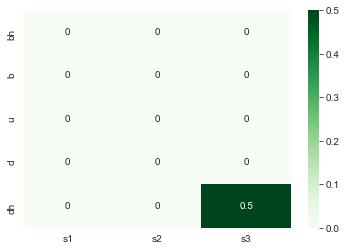

In [43]:
sns.heatmap(harmonies, annot=True, cmap="Greens")

### Pairwise Harmonies:

In [44]:
# Harmonies for the binding : u/s2
harmonies = G.Hcc.numpy()[:,:,0,0]
harmonies = pd.DataFrame(harmonies, columns=roles, index=fillers)
harmonies

,s1,s2,s3
bh,0.0,0.0,0.0
b,0.0,0.0,0.0
u,0.0,0.0,0.0
d,0.0,0.0,0.0
dh,0.0,0.0,0.0


<AxesSubplot:>

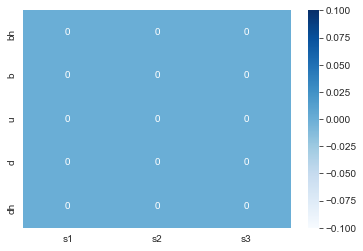

In [45]:
sns.heatmap(harmonies, annot=True, cmap="Blues")

The preceding matrix is the matrix for "u" in second position, the binding "u/s2". We implemented the harmony constraint ("u/s2", "d/s3", -3) and ("u/s2", "dh/s3", 3) and this is what the heatmap is visualizing.

## GSC Net

In [46]:
# Custom settings (these substitute the hard-coded settings)

# ---------------------------------------
#           GSC NET
# ---------------------------------------

custom_settings = {"epochs": 4,
                   "tgtStd": 0.0125,
                   "emaFactor": 0.1,
                   "emaSpeedTol": 0.002,
                   "dt": 1e-5,
                   "TInit" : 1e-8,
                   "TDecayRate": 0.0, # do not change temperature
                   "maxSteps": 50000,
                   "printInterval": 25000}
# Initialize
N = Net(G, custom_settings=custom_settings, extData_path="data/inp_pandas.csv")


Input processed: b-bh-u-dh

Input processed: b-u-dh

Input processed: b-bh-u-dh-d

Value for Q set to 4.500000240002935
LAMBDA RECOMMENDED: 0.05263157628805626, ACTUAL LAMBDA = 0.011387


If you want to change to the recommended Lambda value press 'y', else any other key: y


T RECOMMENDED: 0.0007031250375004587, ACTUAL T = 1e-08


If you want to change to the recommended value press 'y', else any other key: y


The external data were provided in form of a simple csv file and were imported in the GSCNet using `pandas`:

In [47]:
# EXTERNAL INPUTS 

# Read dataframe
inputs = pd.read_csv("data/inp_pandas.csv", sep=",")
inputNames = []
nStimuli = len(inputs['id'].unique())

# Initialize stimuli tensor
stimuli = torch.zeros((nStimuli, len(fillers) + 1, len(roles)))

# Loop over the single inputs as whole
for idx, i in enumerate(inputs['id'].unique()):
    inp_string = ""
    stimulus = inputs[inputs.id == i].to_numpy()[:, 1:]

    # Loop over the fillers in a given input
    for filler in stimulus:
        fidx = N.filler2index[filler[0]]
        inp_string += filler[0] + "-"
        for roledix in range(N.grammar.bind.nR):
            stimuli[idx, fidx, roledix] = filler[roledix+1]
    print(f"Input processed: {inp_string[:-1]}\n")
    # Store the names for later plotting
    inputNames.append(inp_string[:-1])

Input processed: b-bh-u-dh

Input processed: b-u-dh

Input processed: b-bh-u-dh-d



The first imput is a gradient blend for the root *{b, bh}ud*:

     s1   s2   s3
bh  0.7  0.0  0.0
b   0.8  0.0  0.0
u   0.0  1.0  0.0
d   0.0  0.0  0.0
dh  0.0  0.0  1.0


<AxesSubplot:>

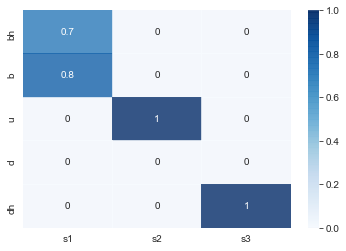

In [48]:
b_bh_ud = N.stimuli[0,:,:].numpy()
b_bh_ud = pd.DataFrame(b_bh_ud, columns=roles, index=fillers)
print(b_bh_ud)
sns.heatmap(b_bh_ud, alpha=.8, cmap="Blues", annot=True)

## Training (Optimization + Quantization)

In [49]:
# Run
p = N()

Stimulus routine::   0%|          | 0/3 [00:00<?, ?it/s]


--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.05263157628805626	 Harmony: 7.486666202545166

epoch : 1
stimNum : 1

Conceptual Matrix:
          s1        s2        s3
bh  0.555555  0.400000  0.400000
b   0.577778  0.400000  0.400000
u   0.400000  0.622222  0.400000
d   0.400000  0.400000  0.400000
dh  0.400000  0.400000  0.733333
Nearest TP: b-u-dh
Distance between prediction and nearest TP: 1.5686745856007411

--------------------------------------------------------------------------------

STEP : 25000	 Lambda : 0.04187720775677202	 Harmony: -50.409759521484375

epoch : 1
stimNum : 1

Conceptual Matrix:
          s1        s2        s3
bh  1.395914  1.077723  1.787960
b   1.400013  1.077236  1.771076
u   1.341347  1.360162  1.944181
d   1.697942  1.441344  2.519163
dh  1.819853  1.529058  3.026669
Nearest TP: dh-dh-dh
Distance between prediction and nearest TP: 6.029863473883685



Stimulus routine::  33%|███▎      | 1/3 [00:31<01:02, 31.40s/it]


Last best Harmony: -167.7534296690578


--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.03332419045854775	 Harmony: 7.27222204208374

epoch : 1
stimNum : 2

Conceptual Matrix:
          s1        s2        s3
bh  0.400000  0.400000  0.400000
b   0.622222  0.400000  0.400000
u   0.400000  0.622222  0.400000
d   0.400000  0.400000  0.400000
dh  0.400000  0.400000  0.733333
Nearest TP: b-u-dh
Distance between prediction and nearest TP: 1.5088216198608275

--------------------------------------------------------------------------------

STEP : 25000	 Lambda : 0.026522468264157134	 Harmony: -56.00056457519531

epoch : 1
stimNum : 2

Conceptual Matrix:
          s1        s2        s3
bh  1.295080  1.115119  1.874683
b   1.488607  1.087691  1.842429
u   1.369105  1.382706  2.015046
d   1.743026  1.474411  2.617079
dh  1.881004  1.577884  3.131180
Nearest TP: dh-dh-dh
Distance between prediction and nearest TP: 6.228052255335096



Stimulus routine::  67%|██████▋   | 2/3 [01:03<00:31, 31.88s/it]


Last best Harmony: -201.71710891193578


--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.021113015592239857	 Harmony: 8.228887557983398

epoch : 1
stimNum : 3

Conceptual Matrix:
          s1        s2        s3
bh  0.555555  0.400000  0.400000
b   0.844444  0.400000  0.400000
u   0.400000  0.622222  0.400000
d   0.400000  0.400000  0.511111
dh  0.400000  0.400000  0.622222
Nearest TP: b-u-dh
Distance between prediction and nearest TP: 1.574644594961648

--------------------------------------------------------------------------------

STEP : 25000	 Lambda : 0.016811189345995358	 Harmony: -58.70920944213867

epoch : 1
stimNum : 3

Conceptual Matrix:
          s1        s2        s3
bh  1.464323  1.124321  1.921655
b   1.729843  1.117078  1.885592
u   1.410748  1.414914  2.068105
d   1.773417  1.492320  2.791298
dh  1.899897  1.602420  3.106669
Nearest TP: dh-dh-dh
Distance between prediction and nearest TP: 6.476123256184211



Stimulus routine::   0%|          | 0/3 [00:00<?, ?it/s]


Last best Harmony: -227.02309757487484


--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.013389919729740902	 Harmony: 7.486666202545166

epoch : 2
stimNum : 1

Conceptual Matrix:
          s1        s2        s3
bh  0.555555  0.400000  0.400000
b   0.577778  0.400000  0.400000
u   0.400000  0.622222  0.400000
d   0.400000  0.400000  0.400000
dh  0.400000  0.400000  0.733333
Nearest TP: b-u-dh
Distance between prediction and nearest TP: 1.5686745856007411

--------------------------------------------------------------------------------

STEP : 25000	 Lambda : 0.010669180992698538	 Harmony: -61.92546844482422

epoch : 2
stimNum : 1

Conceptual Matrix:
          s1        s2        s3
bh  1.483146  1.138060  1.951304
b   1.488862  1.131421  1.913535
u   1.423922  1.435056  2.097477
d   1.799957  1.514385  2.723927
dh  1.932007  1.610623  3.258553
Nearest TP: dh-dh-dh
Distance between prediction and nearest TP: 6.499447544312121



Stimulus routine::  33%|███▎      | 1/3 [00:29<00:59, 29.60s/it]


Last best Harmony: -247.529672039702


--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.008505360270525989	 Harmony: 7.27222204208374

epoch : 2
stimNum : 2

Conceptual Matrix:
          s1        s2        s3
bh  0.400000  0.400000  0.400000
b   0.622222  0.400000  0.400000
u   0.400000  0.622222  0.400000
d   0.400000  0.400000  0.400000
dh  0.400000  0.400000  0.733333
Nearest TP: b-u-dh
Distance between prediction and nearest TP: 1.5088216198608275

--------------------------------------------------------------------------------

STEP : 25000	 Lambda : 0.006784598237957819	 Harmony: -63.941017150878906

epoch : 2
stimNum : 2

Conceptual Matrix:
          s1        s2        s3
bh  1.355570  1.142589  1.978024
b   1.549556  1.129753  1.938121
u   1.441334  1.438277  2.124490
d   1.809209  1.521258  2.750805
dh  1.941411  1.625069  3.295952
Nearest TP: dh-dh-dh
Distance between prediction and nearest TP: 6.5461230253442855



Stimulus routine::  67%|██████▋   | 2/3 [01:02<00:31, 31.54s/it]


Last best Harmony: -262.1163027388894


--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.0054160653122104436	 Harmony: 8.228887557983398

epoch : 2
stimNum : 3

Conceptual Matrix:
          s1        s2        s3
bh  0.555555  0.400000  0.400000
b   0.844444  0.400000  0.400000
u   0.400000  0.622222  0.400000
d   0.400000  0.400000  0.511111
dh  0.400000  0.400000  0.622222
Nearest TP: b-u-dh
Distance between prediction and nearest TP: 1.574644594961648

--------------------------------------------------------------------------------

STEP : 25000	 Lambda : 0.004327749873313425	 Harmony: -63.91896438598633

epoch : 2
stimNum : 3

Conceptual Matrix:
          s1        s2        s3
bh  1.511047  1.149007  1.981402
b   1.769457  1.134922  1.950314
u   1.436924  1.446734  2.134499
d   1.817469  1.532093  2.882470
dh  1.954867  1.632549  3.206244
Nearest TP: dh-dh-dh
Distance between prediction and nearest TP: 6.678667392930233



Stimulus routine::   0%|          | 0/3 [00:00<?, ?it/s]


Last best Harmony: -270.49742473736353


--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.0034622057227914936	 Harmony: 7.486666202545166

epoch : 3
stimNum : 1

Conceptual Matrix:
          s1        s2        s3
bh  0.555555  0.400000  0.400000
b   0.577778  0.400000  0.400000
u   0.400000  0.622222  0.400000
d   0.400000  0.400000  0.400000
dh  0.400000  0.400000  0.733333
Nearest TP: b-u-dh
Distance between prediction and nearest TP: 1.5686745856007411

--------------------------------------------------------------------------------

STEP : 25000	 Lambda : 0.0027738882959048874	 Harmony: -65.53961181640625

epoch : 3
stimNum : 1

Conceptual Matrix:
          s1        s2        s3
bh  1.514001  1.157997  1.983362
b   1.526772  1.157504  1.955790
u   1.443579  1.452003  2.144936
d   1.829792  1.535659  2.784998
dh  1.957385  1.636164  3.333879
Nearest TP: dh-dh-dh
Distance between prediction and nearest TP: 6.639782366746869



Stimulus routine::  33%|███▎      | 1/3 [00:30<01:00, 30.40s/it]


Last best Harmony: -277.5609446161289


--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.002226465093723903	 Harmony: 7.27222204208374

epoch : 3
stimNum : 2

Conceptual Matrix:
          s1        s2        s3
bh  0.400000  0.400000  0.400000
b   0.622222  0.400000  0.400000
u   0.400000  0.622222  0.400000
d   0.400000  0.400000  0.400000
dh  0.400000  0.400000  0.733333
Nearest TP: b-u-dh
Distance between prediction and nearest TP: 1.5088216198608275

--------------------------------------------------------------------------------

STEP : 25000	 Lambda : 0.001791130940386941	 Harmony: -66.08154296875

epoch : 3
stimNum : 2

Conceptual Matrix:
          s1        s2        s3
bh  1.366431  1.160270  1.997510
b   1.569086  1.151566  1.966318
u   1.448267  1.448192  2.143052
d   1.833720  1.542036  2.783726
dh  1.961797  1.643615  3.336374
Nearest TP: dh-dh-dh
Distance between prediction and nearest TP: 6.628184498135667



Stimulus routine::  67%|██████▋   | 2/3 [01:01<00:30, 30.74s/it]


Last best Harmony: -281.6893168379802


--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.0014449069354007151	 Harmony: 8.228887557983398

epoch : 3
stimNum : 3

Conceptual Matrix:
          s1        s2        s3
bh  0.555555  0.400000  0.400000
b   0.844444  0.400000  0.400000
u   0.400000  0.622222  0.400000
d   0.400000  0.400000  0.511111
dh  0.400000  0.400000  0.622222
Nearest TP: b-u-dh
Distance between prediction and nearest TP: 1.574644594961648

--------------------------------------------------------------------------------

STEP : 25000	 Lambda : 0.0011695749190098873	 Harmony: -65.38752746582031

epoch : 3
stimNum : 3

Conceptual Matrix:
          s1        s2        s3
bh  1.515466  1.152170  1.991397
b   1.778984  1.150145  1.975147
u   1.458139  1.454388  2.143579
d   1.831681  1.543423  2.900591
dh  1.957498  1.641890  3.247950
Nearest TP: dh-dh-dh
Distance between prediction and nearest TP: 6.734070329676325



Stimulus routine::   0%|          | 0/3 [00:00<?, ?it/s]


Last best Harmony: -283.30350888197586


--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.0009506016253111383	 Harmony: 7.486666202545166

epoch : 4
stimNum : 1

Conceptual Matrix:
          s1        s2        s3
bh  0.555555  0.400000  0.400000
b   0.577778  0.400000  0.400000
u   0.400000  0.622222  0.400000
d   0.400000  0.400000  0.400000
dh  0.400000  0.400000  0.733333
Nearest TP: b-u-dh
Distance between prediction and nearest TP: 1.5686745856007411

--------------------------------------------------------------------------------

STEP : 25000	 Lambda : 0.0007764647728065834	 Harmony: -66.21862030029297

epoch : 4
stimNum : 1

Conceptual Matrix:
          s1        s2        s3
bh  1.517621  1.152451  2.008726
b   1.521355  1.152434  1.970656
u   1.448067  1.461382  2.149295
d   1.833347  1.544366  2.794417
dh  1.972643  1.646342  3.334904
Nearest TP: dh-dh-dh
Distance between prediction and nearest TP: 6.664455729133877



Stimulus routine::  33%|███▎      | 1/3 [00:31<01:03, 31.60s/it]


Last best Harmony: -285.34720552005865


--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.0006379726328546055	 Harmony: 7.27222204208374

epoch : 4
stimNum : 2

Conceptual Matrix:
          s1        s2        s3
bh  0.400000  0.400000  0.400000
b   0.622222  0.400000  0.400000
u   0.400000  0.622222  0.400000
d   0.400000  0.400000  0.400000
dh  0.400000  0.400000  0.733333
Nearest TP: b-u-dh
Distance between prediction and nearest TP: 1.5088216198608275

--------------------------------------------------------------------------------

STEP : 25000	 Lambda : 0.0005278378080068124	 Harmony: -66.45158386230469

epoch : 4
stimNum : 2

Conceptual Matrix:
          s1        s2        s3
bh  1.344054  1.158855  2.007299
b   1.561242  1.152992  1.968284
u   1.451290  1.457424  2.155362
d   1.851111  1.536821  2.782824
dh  1.966620  1.635962  3.353534
Nearest TP: dh-dh-dh
Distance between prediction and nearest TP: 6.641239528640285



Stimulus routine::  67%|██████▋   | 2/3 [01:04<00:32, 32.23s/it]


Last best Harmony: -286.5374004080742


--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.00044024688536734035	 Harmony: 8.228887557983398

epoch : 4
stimNum : 3

Conceptual Matrix:
          s1        s2        s3
bh  0.555555  0.400000  0.400000
b   0.844444  0.400000  0.400000
u   0.400000  0.622222  0.400000
d   0.400000  0.400000  0.511111
dh  0.400000  0.400000  0.622222
Nearest TP: b-u-dh
Distance between prediction and nearest TP: 1.574644594961648

--------------------------------------------------------------------------------

STEP : 25000	 Lambda : 0.0003705908678742247	 Harmony: -65.79493713378906

epoch : 4
stimNum : 3

Conceptual Matrix:
          s1        s2        s3
bh  1.517498  1.167316  2.002668
b   1.792212  1.143400  1.972779
u   1.465582  1.465509  2.146155
d   1.838880  1.547149  2.906688
dh  1.968289  1.651881  3.238474
Nearest TP: dh-dh-dh
Distance between prediction and nearest TP: 6.751760150917695



Epoch routine:: 100%|██████████| 4/4 [06:20<00:00, 95.16s/it]


Last best Harmony: -286.8631835826589



# Visualization

In [50]:
from src.gsc.plotting import Plot
import matplotlib.pyplot as plt

In [51]:
fp = "data/full_traces.pt"
nr = len(roles)
nf = len(fillers) +1 
statesDict = G.bind.states
inputNames = N.inputNames


p = Plot(fp_traces="data/full_traces.pt", nf=nf,nr=nr, inputNames=inputNames, statesDict=statesDict)

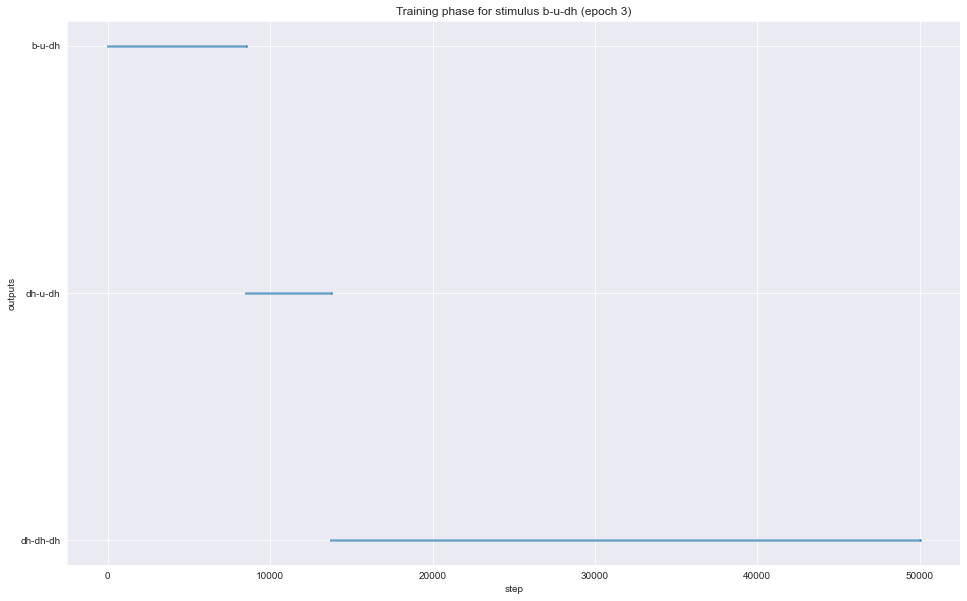

In [52]:
plt.figure(figsize=(16,10))
df = p.plot_epoch(1, 3)

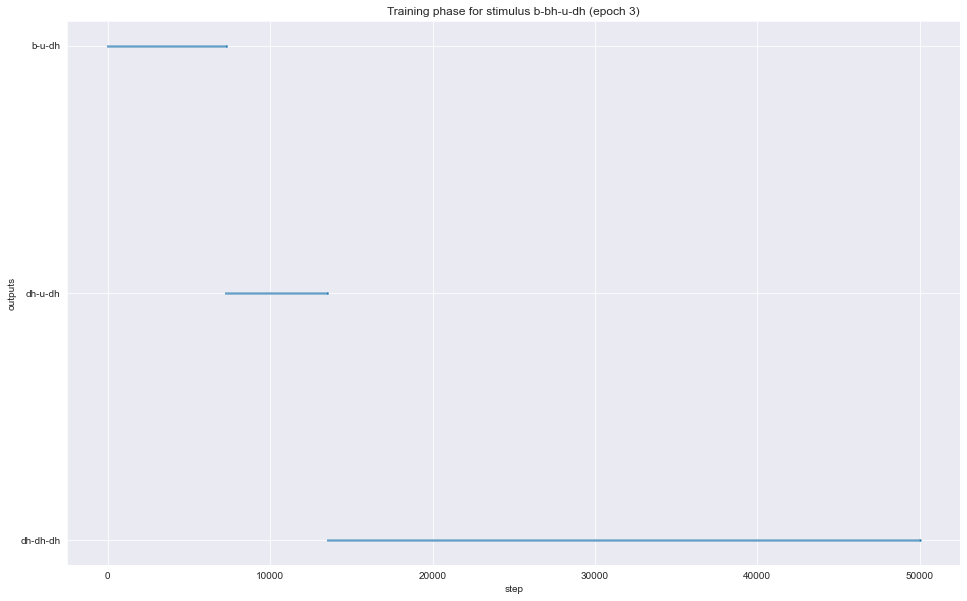

In [53]:
plt.figure(figsize=(16,10))
df = p.plot_epoch(0, 3)

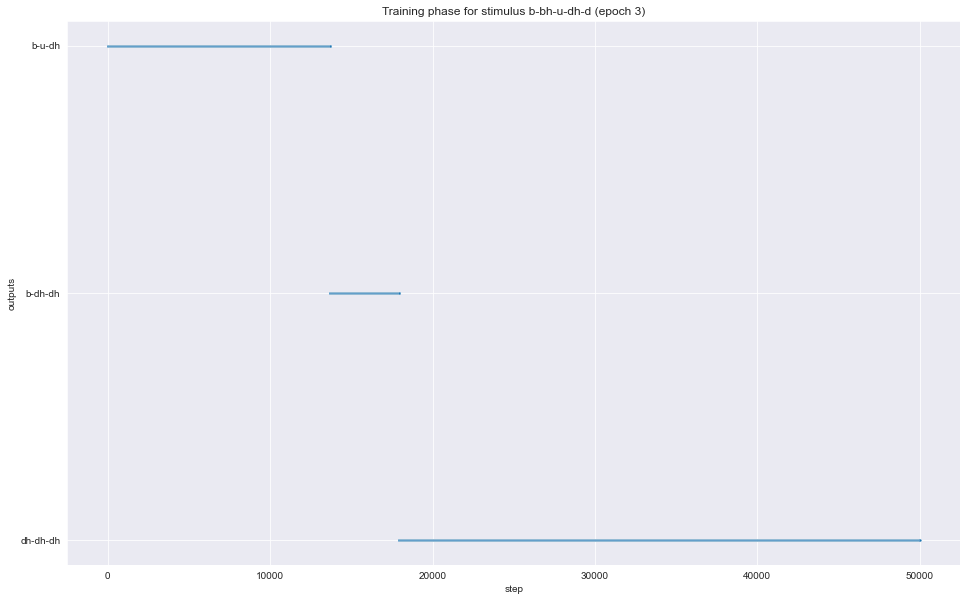

In [54]:
plt.figure(figsize=(16,10))
df = p.plot_epoch(2, 3)

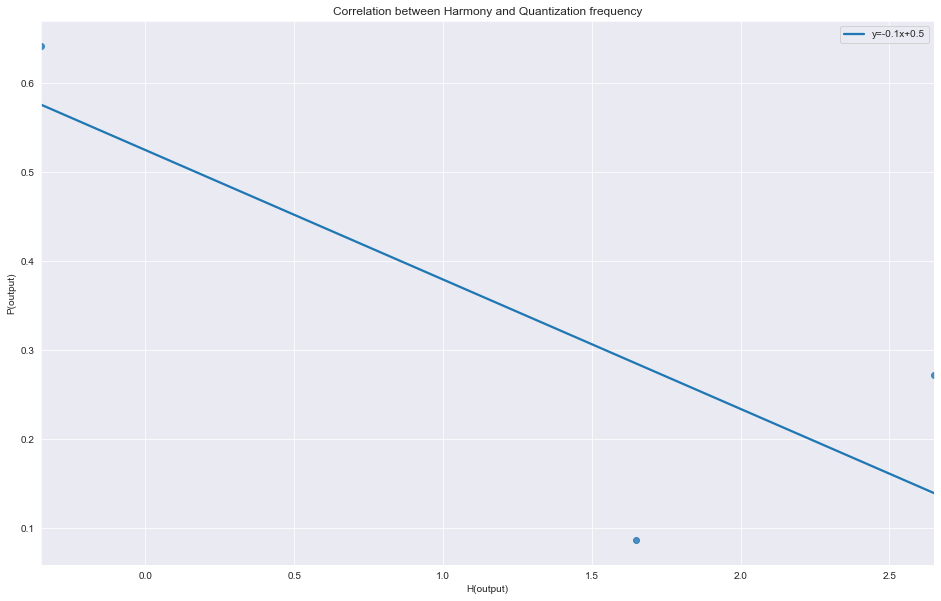

R-coeff: -0.7857884479446293
Slope: -0.14551877684101913
Intercept: 0.5249328154412205


In [55]:
plt.figure(figsize=(16,10))
df = p.plot_harmonyProb(2, 2, lm=False)

In [56]:
df

,outputs,H(output),P(output)
b-u-dh,36.0,2.649997,0.271565
dh-dh-dh,72.0,-0.349999,0.641993
b-dh-dh,107.0,1.649997,0.086442


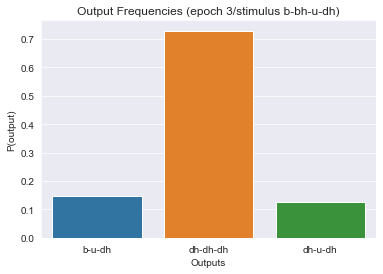

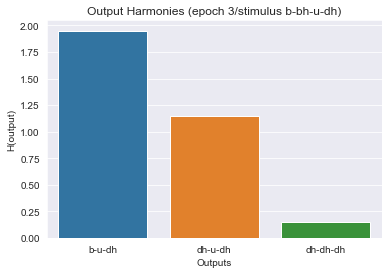

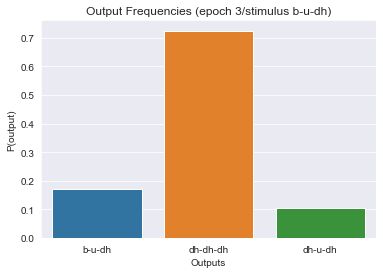

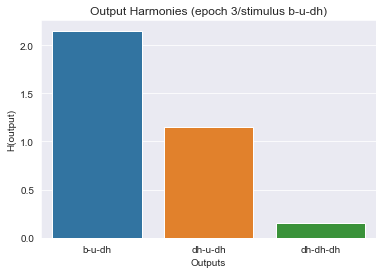

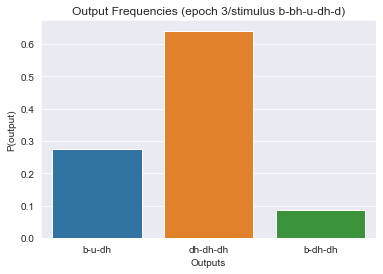

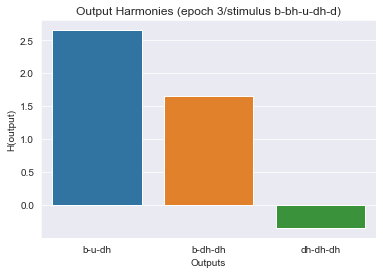

In [57]:
df = p.plot_final_states()

In [59]:
data = p.data
c = data['C_trace']

In [66]:
data['TP_trace']

{'b-bh-u-dh/rep_0': ['b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh',
  'b-u-dh

step: 0 for input b-bh-u-dh 


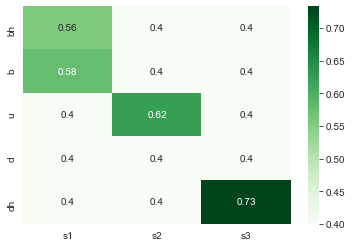

step: 2500 for input b-bh-u-dh 


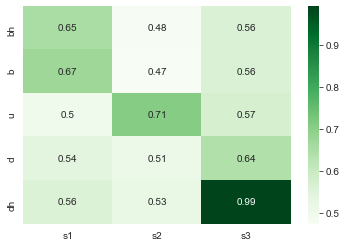

step: 5000 for input b-bh-u-dh 


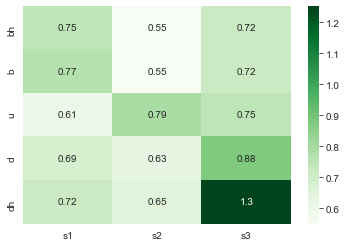

step: 7500 for input b-bh-u-dh 


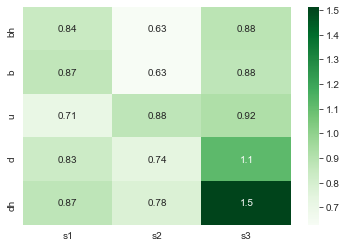

In [65]:
for i in range(0, 10000,2500):
    mat = c[0, 3, i, :, :]
    df = pd.DataFrame(mat.numpy(), index=fillers, columns=roles)
    print(f"step: {i} for input {p.inputNames[0]} ")
    sns.heatmap(df, annot=True, cmap="Greens")
    plt.show()